In [44]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

import matplotlib.pyplot as plt
import pandas as pd

In [45]:
mongo_uri = ""
client = MongoClient(mongo_uri, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


### Importing data and performing basic transformations

In [46]:
db = client['test']
orders_collection = db['orders']
orders_documents = orders_collection.find()
orders_df = pd.DataFrame(orders_documents)
mod_orders_df = orders_df.drop(columns=['createdAt', 'deliveryStatus', '__v', '_id', 'items'])
mod_orders_df = mod_orders_df.groupby(orders_df['createdBy']).aggregate({'totalPrice': 'sum', 'createdBy': 'count'})
mod_orders_df = mod_orders_df.rename(columns={"totalPrice": "totalSpent", 'createdBy': 'totalOrders'});
mod_orders_df

,totalSpent,totalOrders
createdBy,,
64eeea7d00e301281e3de04b,267675.29,17
64eeea7d00e301281e3de04c,482816.06,25
64eeea7d00e301281e3de04d,361984.78,20
64eeea7d00e301281e3de04e,239445.66,16
64eeea7d00e301281e3de04f,347929.91,23
...,...,...
64eeea7d00e301281e3de42e,496013.77,44
64eeea7d00e301281e3de42f,612144.62,30
64eeea7d00e301281e3de430,670792.71,45


### EDA on the data

In [47]:
# I should 1/10 the price of everything
mod_orders_df.describe()

,totalSpent,totalOrders
count,1000.000000,1000.000000
mean,301461.222560,20.000000
std,91753.275046,4.708946
min,74119.280000,8.000000
25%,241342.520000,17.000000
50%,294809.040000,20.000000
75%,355461.940000,23.000000
max,699995.270000,45.000000


### Finding outliers and scaling

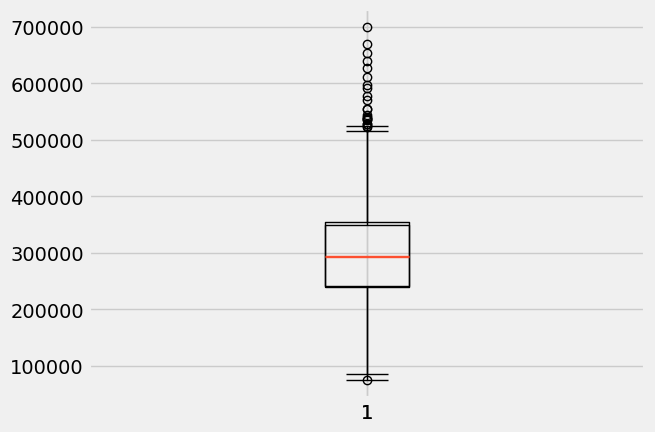

In [48]:
### FOR totalSpent
# Before removing outliers
orders_ts_boxplot = plt.boxplot(mod_orders_df['totalSpent'])

# Removing outliers
orders_ts_outliers = orders_ts_boxplot['fliers'][0].get_ydata()
mod_orders_df = mod_orders_df[~mod_orders_df['totalSpent'].isin(orders_ts_outliers)]

# After removing outliers
orders_ts_boxplot = plt.boxplot(mod_orders_df['totalSpent'])
orders_ts_outliers = orders_ts_boxplot['fliers'][0].get_ydata()

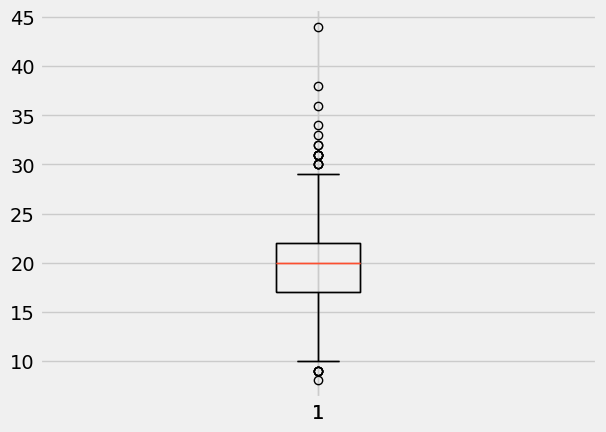

In [49]:
### FOR totalOrders
# Before removing outliers
orders_to_boxplot = plt.boxplot(mod_orders_df['totalOrders'])

# Removing outliers
orders_to_outliers = orders_to_boxplot['fliers'][0].get_ydata()
mod_orders_df = mod_orders_df[~mod_orders_df['totalOrders'].isin(orders_to_outliers)]

# After removing outliers
orders_to_boxplot = plt.boxplot(mod_orders_df['totalOrders'])
orders_to_outliers = orders_to_boxplot['fliers'][0].get_ydata()

In [50]:
# Scaling
scaler = StandardScaler()
mod_orders_df = scaler.fit_transform(mod_orders_df)

### Finding a suitable number of clusters

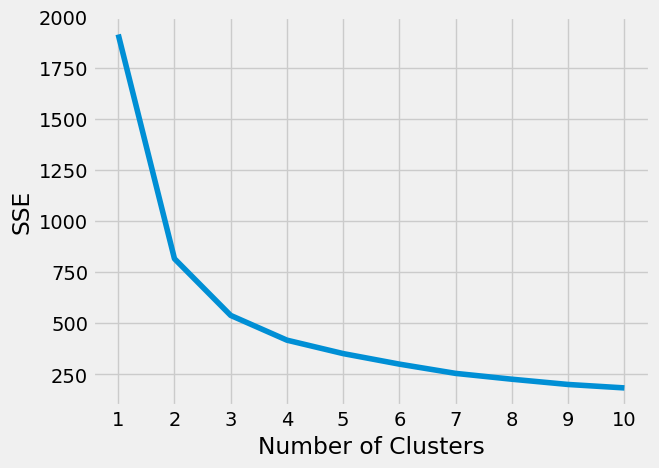

In [51]:
# Elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(mod_orders_df)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [52]:
# Confirm elbow point found from above test
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

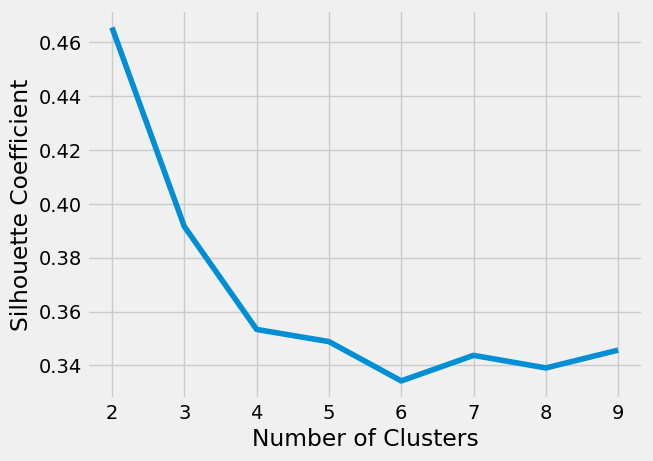

In [53]:
# Silhoutte score
silhouette_coefficients = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(mod_orders_df)
    score = silhouette_score(mod_orders_df, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# The decision was made to go forward with 3 clusters.

### Applying the classification

In [54]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(mod_orders_df)
kmeans.inertia_
kmeans.cluster_centers_
kmeans.n_iter_
kmeans.labels_[:5]

array([0, 1, 0, 2, 1])